<a href="https://colab.research.google.com/github/Markfryazino/stanford_sentiment/blob/master/research/lstm_for_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2020-07-02 14:50:23--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  21.4MB/s    in 6.7s    

2020-07-02 14:50:30 (12.0 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [2]:
import numpy as np
import pandas as pd

PATH = './'

import os
train_pos_names = os.listdir(PATH + 'aclImdb/train/pos')
train_neg_names = os.listdir(PATH + 'aclImdb/train/neg')
test_pos_names = os.listdir(PATH + 'aclImdb/test/pos')
test_neg_names = os.listdir(PATH + 'aclImdb/test/neg')

In [3]:
y_train = [int(s.split('_')[1].split('.')[0]) for s in train_pos_names] + \
          [int(s.split('_')[1].split('.')[0]) for s in train_neg_names]
    
y_test = [int(s.split('_')[1].split('.')[0]) for s in test_pos_names] + \
          [int(s.split('_')[1].split('.')[0]) for s in test_neg_names]

In [4]:
train = []
test = []

for name in train_pos_names:
    with open(PATH + 'aclImdb/train/pos/' + name) as f:
        train.append(f.read())
        
for name in train_neg_names:
    with open(PATH + 'aclImdb/train/neg/' + name) as f:
        train.append(f.read())
        
for name in test_pos_names:
    with open(PATH + 'aclImdb/test/pos/' + name) as f:
        test.append(f.read())
        
for name in test_neg_names:
    with open(PATH + 'aclImdb/test/neg/' + name) as f:
        test.append(f.read())

In [5]:
from sklearn.model_selection import train_test_split

train, val, y_train, y_val = train_test_split(train, y_train, shuffle=True, test_size=0.2)

In [6]:
text = 'a b c c c d d a'
from collections import Counter
c = dict(Counter(text.split()))
c = {key for key, val in c.items() if val >= 3}
c

{'c'}

In [7]:
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

class Tokenizer:
    def __init__(self, data, maxlen=1024, mincount=3):
        self.maxlen = maxlen
        self.mincount = mincount
        text = ' '.join(data).lower()
        text = re.sub(r'[^\w\s]','',text)
        words = dict(Counter((text.split())))
        words = {key for key, val in words.items() if val >= mincount}
        self.num_tokens = len(words) + 4
        self.w2i = {'<unk>': 0, '<BOS>': 1, '<EOS>': 2, '<pad>': 3}
        self.i2w = ['<unk', '<BOS>', '<EOS>', '<pad>']
        for w in words:
            self.w2i[w] = len(self.i2w)
            self.i2w.append(w)
    
    def tokenize(self, data):
        output = []
        for sent in data:
            text = re.sub(r'[^\w\s]','',sent.lower())
            output.append([1])
            for w in text.split():
                if w in self.w2i:
                    output[-1].append(self.w2i[w])
                else:
                    output[-1].append(0)
            output[-1].append(2)
        return pad_sequences(output, maxlen=self.maxlen, value=3)

In [8]:
tok = Tokenizer(train, maxlen=512, mincount=3)

In [9]:
train_tok = tok.tokenize(train)
val_tok = tok.tokenize(val)
test_tok = tok.tokenize(test)

In [10]:
import torch
from torch import nn

class SimpleModel(nn.Module):
    def __init__(self, num_tokens, emb_size=16, hid_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.dropout = nn.Dropout(p=0.3)
        self.lstm = nn.LSTM(emb_size, hid_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hid_size, 1)
        
    def forward(self, x):
        x = x.type(torch.LongTensor).to(device)
        emb = self.dropout(self.emb(x))
        h, _ = self.lstm(emb)
        estimate = self.fc(h[:, -1, :])
        return torch.flatten(estimate)

In [11]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, data, y):
        self.data = data
        self.y = y
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.y[idx]

In [12]:
train_dset = TextDataset(train_tok, y_train)
val_dset = TextDataset(val_tok, y_val)
test_dset = TextDataset(test_tok, y_test)

In [13]:
train_loader = DataLoader(train_dset, batch_size=16)
val_loader = DataLoader(val_dset, batch_size=16)
test_loader = DataLoader(test_dset, batch_size=16)

device = torch.device("cuda:0")

In [14]:
def compute_quality(model, loader, classification=False):
    model.eval()
    
    loss_acum = 0.
    correct = total = 0
    
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)

        if classification:
            y_gpu = (y > 5).type(torch.FloatTensor).to(device)

        pred = model(x_gpu)
        loss_val = loss(pred, y_gpu)
        loss_acum += loss_val
        
        pred_rounded = torch.round(pred)
        correct += torch.sum(pred_rounded == y_gpu)
        total += y.shape[0]
        del x_gpu, y_gpu
        
    return loss_acum / (i_step + 1), float(correct) / total

def train_model(model, train_loader, val_loader, epochs, optimizer, loss, plato_scheduler=None, 
                scheduler=None, classification=False):
    loss_history = []
    acc_history = []
    
    for epoch in range(epochs):
        model.train()
        
        loss_acum = 0.
        correct = total = 0
        
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)

            if classification:
                y_gpu = (y > 5).type(torch.FloatTensor).to(device)

            pred = model(x_gpu)
            loss_val = loss(pred, y_gpu)
            loss_acum += loss_val
            
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            
            pred_rounded = torch.round(pred)
            correct += torch.sum(pred_rounded == y_gpu)
            total += y.shape[0]
            del x_gpu, y_gpu
            
        train_acc = float(correct) / total
        train_loss = loss_acum / (i_step + 1)
        
        val_loss, val_acc = compute_quality(model, val_loader, classification=classification)
        loss_history.append(val_loss)
        acc_history.append(val_acc)

        if plato_scheduler != None:
            scheduler.step(val_acc)
        if scheduler != None:
            scheduler.step()
        
        print(f'Epoch {epoch}\nTrain loss: {train_loss}\nTrain accuracy: {train_acc}')
        print(f'Val loss: {val_loss}\nVal accuracy: {val_acc}')
    return loss_history, acc_history

In [19]:
model = nn.Sequential(
    SimpleModel(tok.num_tokens, 16, 32),
    nn.Sigmoid()
)

model.to(device)
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='max')
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer, 2, 0.1)

loss_hist, acc_hist = train_model(model, train_loader, val_loader, 10, optimizer, loss, 
                                   classification=True, plato_scheduler=scheduler1, scheduler=scheduler2)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0
Train loss: 0.6705866456031799
Train accuracy: 0.5716
Val loss: 0.6306892037391663
Val accuracy: 0.6412
Epoch 1
Train loss: 0.5943325161933899
Train accuracy: 0.68505
Val loss: 0.5425017476081848
Val accuracy: 0.7288
Epoch 2
Train loss: 0.5280731916427612
Train accuracy: 0.74805
Val loss: 0.5004121661186218
Val accuracy: 0.7672
Epoch 3
Train loss: 0.47268837690353394
Train accuracy: 0.7863
Val loss: 0.43972328305244446
Val accuracy: 0.8048
Epoch 4
Train loss: 0.423369824886322
Train accuracy: 0.81535
Val loss: 0.41856592893600464
Val accuracy: 0.8098
Epoch 5
Train loss: 0.37628108263015747
Train accuracy: 0.8396
Val loss: 0.38602039217948914
Val accuracy: 0.8366
Epoch 6
Train loss: 0.37803909182548523
Train accuracy: 0.8385
Val loss: 0.4224628210067749
Val accuracy: 0.8228
Epoch 7
Train loss: 0.33113738894462585
Train accuracy: 0.86295
Val loss: 0.41826242208480835
Val accuracy: 0.8448
Epoch 8
Train loss: 0.29100584983825684
Train accuracy: 0.8794
Val loss: 0.3850339651107788
V

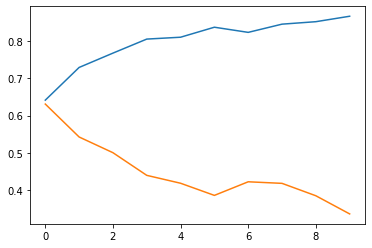

In [26]:
import matplotlib.pyplot as plt
plt.plot(range(10), val_hist)
plt.plot(range(10), train_hist)

In [24]:
import joblib

torch.save(model.state_dict(), PATH + 'classification.pt')
joblib.dump(tok, PATH + 'tokenizer.joblib')

['./tokenizer.joblib']

In [18]:
reg_model = model[0].to(device)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='max')

train_hist, val_hist = train_model(reg_model, train_loader, val_loader, 10, optimizer, loss)

Epoch 0
Train loss: 12.872408866882324
Train accuracy: 0.0078
Val loss: 11.108055114746094
Val accuracy: 0.0294
Epoch 1
Train loss: 9.667640686035156
Train accuracy: 0.08345
Val loss: 8.611762046813965
Val accuracy: 0.122
Epoch 2
Train loss: 7.752617835998535
Train accuracy: 0.1314
Val loss: 7.709372520446777
Val accuracy: 0.1452
Epoch 3
Train loss: 6.0280442237854
Train accuracy: 0.1564
Val loss: 6.495204925537109
Val accuracy: 0.1532
Epoch 4
Train loss: 4.992058277130127
Train accuracy: 0.1738
Val loss: 6.6857590675354
Val accuracy: 0.1644
Epoch 5
Train loss: 4.746802806854248
Train accuracy: 0.17555
Val loss: 6.718478202819824
Val accuracy: 0.1514
Epoch 6
Train loss: 3.9804162979125977
Train accuracy: 0.19385
Val loss: 6.276157379150391
Val accuracy: 0.2086


RuntimeError: ignored